In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f
import pandas as pd

core = 4  # set number of cores here

spark = SparkSession.builder \
    .master(f"local[{core}]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .appName("FraudKMeansExperiment") \
    .getOrCreate()

sc = spark.sparkContext


In [4]:
df = spark.read.csv("/content/drive/MyDrive/csc735spring2025/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)

In [5]:
df.show(5)
df.printSchema()

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [6]:
df = df.withColumn("isFlaggedFraud", df["isFlaggedFraud"].cast("int"))


In [7]:
df = df.filter(
    ~sql_f.isnull('amount') &
    ~sql_f.isnull('oldbalanceOrg') &
    ~sql_f.isnull('newbalanceOrig') &
    ~sql_f.isnull('oldbalanceDest') &
    ~sql_f.isnull('newbalanceDest') &
    ~sql_f.isnull('isFraud') &
    ~sql_f.isnull('isFlaggedFraud')
)

df.show(5)


+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import pandas as pd
import numpy as np

# Drop non-numeric or non-useful columns for clustering
drop_cols = ['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']  # drop strings and label
sample_df = df.sample(fraction=0.1)  # take 10% sample

y_true = sample_df.select('isFraud').toPandas().astype(str)

X = sample_df.drop(*drop_cols).toPandas()

# Standardize numeric features
X_scaled = StandardScaler().fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Map cluster ids to majority class labels
mapped_labels = np.empty_like(clusters, dtype=object)

for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    true_labels_in_cluster = y_true.values.flatten()[mask]
    values, counts = np.unique(true_labels_in_cluster, return_counts=True)
    majority_label = values[np.argmax(counts)]
    mapped_labels[mask] = majority_label

# Accuracy
accuracy = accuracy_score(y_true, mapped_labels)
print(f"KMeans Accuracy (label-mapped): {accuracy:.4f}")


KMeans Accuracy (label-mapped): 0.9987


In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Assemble features
feature_cols = [col for col in df.columns if col not in ['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']]
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_vector = assembler.transform(df)

# Step 2: Fit KMeans
kmeans = KMeans(k=2, seed=42, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(df_vector)

# Step 3: Predict clusters
predictions = model.transform(df_vector)

# Step 4: Convert to Pandas for label mapping and evaluation
preds_pd = predictions.select('isFraud', 'cluster').toPandas()

# Step 5: Manual cluster-to-label mapping
y_true = preds_pd['isFraud'].astype(str).values
clusters = preds_pd['cluster'].values

mapped_labels = np.empty_like(clusters, dtype=object)

for cluster_id in np.unique(clusters):
    mask = clusters == cluster_id
    labels_in_cluster = y_true[mask]
    values, counts = np.unique(labels_in_cluster, return_counts=True)
    majority_label = values[np.argmax(counts)]
    mapped_labels[mask] = majority_label

# Step 6: Compute accuracy
accuracy = accuracy_score(y_true, mapped_labels)
print(f"KMeans Accuracy (after label mapping): {accuracy:.4f}")


KMeans Accuracy (after label mapping): 0.9987


In [14]:
from matplotlib import pyplot as plt

def plot_scalability_measure(name, stats, xlabel, x_vals, linear_vals):
    # Create the plot
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(
        f"{name.capitalize()} for Fraud Detection with K-Means Clustering"
    )

    # Plot the measure with and without overhead
    ax[0].plot(x_vals, stats[name], "k", label=f"Real {name}")
    ax[1].plot(x_vals, stats[f"{name}_no_overhead"], "k",
               label=f"{name} without overhead")

    # Plot the linear values for the measure
    for i in [0, 1]:
        ax[i].plot(x_vals, linear_vals, "--", color="gray",
                   label=f"Linear {name}", linewidth=1)
        ax[i].set(xlabel=xlabel, ylabel=name.capitalize())
        if name == "scale-up":
            ax[i].set_ylim([0, 1.1])
        ax[i].legend()


In [15]:
import os
os.chdir('/content/drive/MyDrive/csc735spring2025')

SPEED-UP

In [17]:
num_cores = [1, 2, 4, 8, 12]
for j in num_cores:
    !python fraud_kmeans.py {j} 100 speedup.csv


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 05:51:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/08 05:52:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/08 05:54:10 WARN MemoryStore: Not enough space to cache rdd_34_2 in memory! (computed 69.4 MiB so far)
25/05/08 05:54:10 WARN BlockManager: Persisting block rdd_34_2 to disk instead.
25/05/08 05:54:34 WARN MemoryStore: Not enough space to cache rdd_34_2 in memory! (computed 69.4 MiB so far)
25/05/08 05:54:49 WARN MemoryStore: Not enough space to cache rdd_34_3 in memory! (computed 69.4 MiB so far)
25/05/08 05:54:49 WARN BlockManager: Persisting block rdd_34_3 to disk instead.
25/05/08 05:55:01 WARN MemoryStore: Not enough space to cache rdd_34_3 in memory! (computed 69.4 MiB so far)
25/05/08 05:55:05 WARN MemorySto

In [18]:
def speed_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [19]:
import pandas as pd
avg_results = pd.read_csv('speedup.csv.csv', names=['cores', 'pct',
                      'runtime', 'runtime_no_overhead'])


In [22]:

avg_results = avg_results[avg_results['runtime'] != 'runtime'].copy()

avg_results['runtime'] = pd.to_numeric(avg_results['runtime'], errors='coerce')
avg_results['runtime_no_overhead'] = pd.to_numeric(avg_results['runtime_no_overhead'], errors='coerce')
avg_results['cores'] = pd.to_numeric(avg_results['cores'], errors='coerce')


avg_results = avg_results.dropna(subset=['runtime', 'runtime_no_overhead', 'cores'])


def speed_up(df, runtime_col):
    min_core = df['cores'].min()
    base_time = df[df['cores'] == min_core][runtime_col].values[0]
    return base_time / df[runtime_col]


avg_results['speed-up'] = speed_up(avg_results, 'runtime')
avg_results['speed-up_no_overhead'] = speed_up(avg_results, 'runtime_no_overhead')


print(avg_results[['cores', 'runtime', 'runtime_no_overhead', 'speed-up', 'speed-up_no_overhead']])


    cores  runtime  runtime_no_overhead  speed-up  speed-up_no_overhead
1     100  430.486                0.144  1.000000              1.000000
2     100  377.205                0.092  1.141252              1.565217
4     100  362.004                0.174  1.189175              0.827586
8     100  357.320                0.091  1.204763              1.582418
12    100  366.963                0.419  1.173105              0.343675


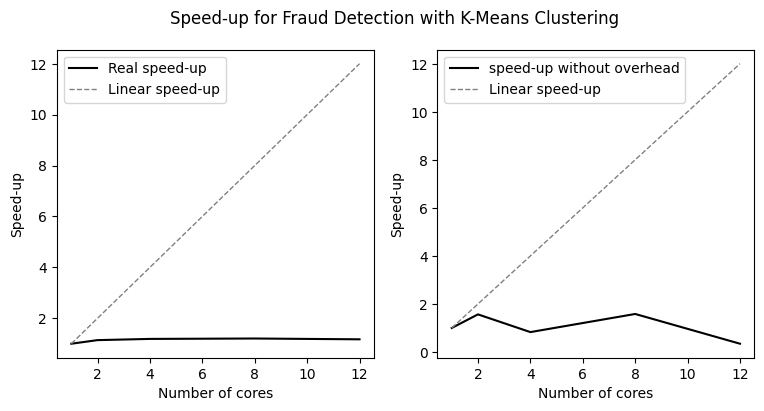

In [23]:
plot_scalability_measure('speed-up', avg_results, 'Number of cores',
                         num_cores, num_cores)

SIZE-UP

In [ ]:
import time
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

def run_kmeans_experiment(df, feature_cols, label_col, cores_label, pct, k=2):
    df_sample = df.sample(withReplacement=False, fraction=pct, seed=42)

    # Step 1: Assemble features
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    df_vector = assembler.transform(df_sample)

    # Split into "train" and "test" just for consistent logic (although clustering is unsupervised)
    df_train, df_test = df_vector.randomSplit([0.7, 0.3], seed=123)

    # Step 2: Full runtime measurement
    full_start = time.time()

    kmeans = KMeans(k=k, seed=42, featuresCol='features', predictionCol='cluster')
    model_start = time.time()
    model = kmeans.fit(df_train)
    predictions = model.transform(df_test)
    model_end = time.time()

    full_end = time.time()

    # Step 3: Evaluate using external label mapping
    preds_pd = predictions.select(label_col, 'cluster').toPandas()

    y_true = preds_pd[label_col].astype(str).values
    clusters = preds_pd['cluster'].values

    mapped_labels = np.empty_like(clusters, dtype=object)
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        labels_in_cluster = y_true[mask]
        values, counts = np.unique(labels_in_cluster, return_counts=True)
        majority_label = values[np.argmax(counts)]
        mapped_labels[mask] = majority_label

    accuracy = accuracy_score(y_true, mapped_labels)

    return {
        'cores': cores_label,
        'pct': int(pct * 100),
        'runtime': round(full_end - full_start, 2),
        'runtime_no_overhead': round(model_end - model_start, 2),
        'accuracy': round(accuracy, 4)
    }

# Example usage
core_label = 4  # change manually for different runs


feature_cols = [col for col in df.columns if col not in ['type', 'nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud']]

results = []

for pct in [0.1, 0.2, 0.4, 0.8, 1.0]:
    result = run_kmeans_experiment(df, feature_cols, 'isFraud', core_label, pct)
    results.append(result)

# Display results as a DataFrame
results_df = pd.DataFrame(results)
print(results_df)


   cores  pct  runtime  runtime_no_overhead  accuracy
0      4   10   119.81               119.76    0.9986
1      4   20   118.23               118.22    0.9987
2      4   40   157.46               157.46    0.9988
3      4   80   191.59               191.58    0.9987
4      4  100   224.91               224.90    0.9987


In [26]:
def size_up(results, runtime_col):
    return results[runtime_col] / results[runtime_col].iloc[0]

In [27]:
results_df['size-up'] = size_up(results_df, 'runtime')
results_df['size-up_no_overhead'] = size_up(results_df,
        'runtime_no_overhead')
results_df[['runtime', 'runtime_no_overhead', 'size-up',
            'size-up_no_overhead']]

,runtime,runtime_no_overhead,size-up,size-up_no_overhead
0,119.81,119.76,1.000000,1.000000
1,118.23,118.22,0.986812,0.987141
2,157.46,157.46,1.314248,1.314796
3,191.59,191.58,1.599115,1.599699
4,224.91,224.90,1.877222,1.877923


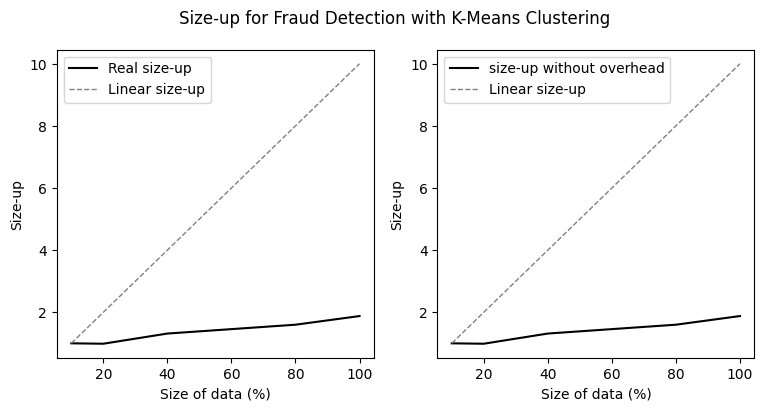

In [28]:
linear_sizeup = [1, 2, 4, 8, 10]
sizes = [10, 20, 40, 80, 100]
plot_scalability_measure('size-up', results_df, 'Size of data (%)',
                         sizes, linear_sizeup)

SCALE-UP

In [29]:
num_cores = [1, 2, 4, 8, 10]
sizes = [10, 20, 40, 80, 100]

In [30]:
for j in range(len(num_cores)):
  !python fraud_kmeans.py {num_cores[j]} \
  {sizes[j]} scaleup.csv

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 07:06:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/08 07:06:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Results written to scaleup.csv.csv
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 07:09:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/08 07:09:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Results written to scaleup.csv.csv
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/08 07:13:08 WARN NativeCodeLoader: Unable to load 

In [31]:
import pandas as pd
results = pd.read_csv("scaleup.csv.csv",
    names=["cores", "pct", "runtime", "runtime_no_overhead"],
)

In [32]:
def scale_up(results, runtime_col):
    return results[runtime_col].iloc[0] / results[runtime_col]

In [34]:
# Clean up bad rows
results = results[results['runtime'] != 'runtime'].copy()

# Convert to numeric
results['runtime'] = pd.to_numeric(results['runtime'], errors='coerce')
results['runtime_no_overhead'] = pd.to_numeric(results['runtime_no_overhead'], errors='coerce')

# Drop NaNs
results = results.dropna(subset=['runtime', 'runtime_no_overhead'])

# Define scale-up function
def scale_up(df, runtime_col):
    base_time = df[df['pct'] == df['pct'].min()][runtime_col].values[0]
    return df[runtime_col] / base_time

# Compute scale-up
results['scale-up'] = scale_up(results, 'runtime')
results['scale-up_no_overhead'] = scale_up(results, 'runtime_no_overhead')

# Display
print(results[['runtime', 'runtime_no_overhead', 'scale-up', 'scale-up_no_overhead']])


    runtime  runtime_no_overhead  scale-up  scale-up_no_overhead
1   120.465                0.133  1.000000              1.000000
2   122.732                0.089  1.018819              0.669173
4   148.056                0.087  1.229037              0.654135
8   270.486                0.111  2.245349              0.834586
10  344.117                0.097  2.856572              0.729323


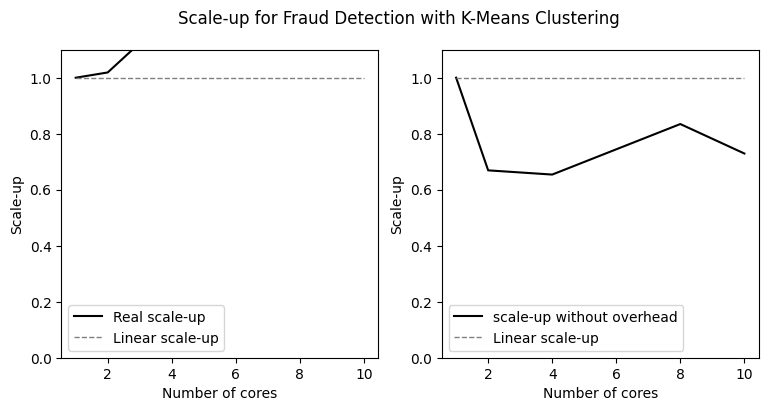

In [35]:
ideal_scaleup = [1] * 5
plot_scalability_measure('scale-up', results, 'Number of cores',
                         num_cores, ideal_scaleup)